# Plot M2 amplitude and phase for tidal runs and for FES2014

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
import scipy.stats
from cartopy import crs as ccrs
import xarray as xr
import xesmf as xe

from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm


### Load data

In [3]:
#define filenames

relative_data_dir_path="../data/raw/"  # Note that this points to /gws/nopw/j04/class_vol2/senemo in this example

# first, the T-grid files for the tidal analysis of SSH

fname_tide_ssh=[relative_data_dir_path+'RUNS2024r01/GS1p1_tide/output/SENEMO_1y_19810101_19811231_grid_T_2D.nc'] 
fname_tide_ssh.append(relative_data_dir_path+'RUNS2024r01/GS1p2_full/output/SENEMO_1y_19810101_19811231_grid_T_2D.nc')
fname_tide_ssh.append(relative_data_dir_path+'EXPIWD02/output/SENEMO_1y_19780101_19781231_grid_T_2D.nc')
fname_tide_ssh.append(relative_data_dir_path+'EXP_GS1p6_full_IWD_soenhance_SSR_ice/SENEMO_1y_19810101_19811231_grid_T_2D.nc')

# then the same for the U- and V-grid files, for the tidal analysis of U_barotropic and V_barotropic

fname_tide_u=[relative_data_dir_path+'RUNS2024r01/GS1p1_tide/output/SENEMO_1y_19810101_19811231_grid_U_2D.nc']
fname_tide_u.append(relative_data_dir_path+'RUNS2024r01/GS1p2_full/output/SENEMO_1y_19810101_19811231_grid_U_2D.nc')
fname_tide_u.append(relative_data_dir_path+'EXPIWD02/output/SENEMO_1y_19780101_19781231_grid_U_2D.nc')
fname_tide_u.append(relative_data_dir_path+'EXP_GS1p6_full_IWD_soenhance_SSR_ice/SENEMO_1y_19810101_19811231_grid_U_2D.nc')


fname_tide_v=[relative_data_dir_path+'RUNS2024r01/GS1p1_tide/output/SENEMO_1y_19810101_19811231_grid_V_2D.nc']
fname_tide_v.append(relative_data_dir_path+'RUNS2024r01/GS1p2_full/output/SENEMO_1y_19810101_19811231_grid_V_2D.nc')
fname_tide_v.append(relative_data_dir_path+'EXPIWD02/output/SENEMO_1y_19780101_19781231_grid_V_2D.nc')
fname_tide_v.append(relative_data_dir_path+'EXP_GS1p6_full_IWD_soenhance_SSR_ice/SENEMO_1y_19810101_19811231_grid_V_2D.nc')

#open files

ds_ssh_GS1p1_tide=xr.open_dataset(fname_tide_ssh[0])
ds_ssh_GS1p2_full=xr.open_dataset(fname_tide_ssh[1])
ds_ssh_EXPIWD02=xr.open_dataset(fname_tide_ssh[2])
ds_ssh_GS1p6_full_IWD_soenhance_SSR_ice=xr.open_dataset(fname_tide_ssh[3])


ds_u_GS1p1_tide=xr.open_dataset(fname_tide_u[0])
ds_u_GS1p2_full=xr.open_dataset(fname_tide_u[1])
ds_u_EXPIWD02=xr.open_dataset(fname_tide_u[2])
ds_u_GS1p6_full_IWD_soenhance_SSR_ice=xr.open_dataset(fname_tide_u[3])


ds_v_GS1p1_tide=xr.open_dataset(fname_tide_v[0])
ds_v_GS1p2_full=xr.open_dataset(fname_tide_v[1])
ds_v_EXPIWD02=xr.open_dataset(fname_tide_v[2])
ds_v_GS1p6_full_IWD_soenhance_SSR_ice=xr.open_dataset(fname_tide_v[3])

In [4]:
ds_v_GS1p6_full_IWD_soenhance_SSR_ice

<xarray.Dataset>
Dimensions:         (y: 1207, x: 1442, nvertex: 4)
Coordinates:
    nav_lat         (y, x) float32 ...
    nav_lon         (y, x) float32 ...
Dimensions without coordinates: y, x, nvertex
Data variables: (12/23)
    bounds_nav_lon  (y, x, nvertex) float32 ...
    bounds_nav_lat  (y, x, nvertex) float32 ...
    area            (y, x) float32 ...
    M2x_v           (y, x) float32 ...
    M2y_v           (y, x) float32 ...
    S2x_v           (y, x) float32 ...
    ...              ...
    K2x_v           (y, x) float32 ...
    K2y_v           (y, x) float32 ...
    P1x_v           (y, x) float32 ...
    P1y_v           (y, x) float32 ...
    MS4x_v          (y, x) float32 ...
    MS4y_v          (y, x) float32 ...
Attributes:
    name:         SENEMO_1y_19810101_19811231_grid_V_2D
    description:  tidal harmonics
    title:        tidal harmonics
    Conventions:  CF-1.6
    timeStamp:    2024-May-11 05:46:54 GMT
    uuid:         4cbc2ccc-4613-4aed-93e0-c2fdd90acdbc

### Load the model grid for ZPS and MES 

In [5]:
# Load the model grid for ZPS and MES 
fn_domcfg_ZPS= relative_data_dir_path + "RUNS2024r01/GS1p1_tide/config/domain_cfg.nc"  #symbolic link, which points to correct file
fn_domcfg_MES= relative_data_dir_path + "RUNS2024r01/GS1p2_full/config/domain_cfg.nc"  #symbolic link, which points to correct file
domcfgZPS = xr.open_dataset(fn_domcfg_ZPS)  
domcfgMES = xr.open_dataset(fn_domcfg_MES)

### Load the FES2014 tidal data

In [6]:
relative_FES_data_dir_path="../data/external/FES2014/"  #currently, this points to /gws/nopw/j04/class_vol2/senemo/shared/FES2014/

fn_FES2014_M2 = relative_FES_data_dir_path + "M2_z.nc"
m2fes=xr.open_dataset(fn_FES2014_M2)

fn_FES2014_S2 = relative_FES_data_dir_path + "S2_z.nc"
s2fes=xr.open_dataset(fn_FES2014_S2)

fn_FES2014_K1= relative_FES_data_dir_path + "K1_z.nc"
k1fes=xr.open_dataset(fn_FES2014_K1)

fn_FES2014_K2 = relative_FES_data_dir_path + "K2_z.nc"
k2fes=xr.open_dataset(fn_FES2014_K2)

fn_FES2014_N2= relative_FES_data_dir_path + "N2_z.nc"
n2fes=xr.open_dataset(fn_FES2014_N2)

fn_FES2014_O1 = relative_FES_data_dir_path + "O1_z.nc"
o1fes=xr.open_dataset(fn_FES2014_O1)

fn_FES2014_P1 = relative_FES_data_dir_path + "P1_z.nc"
p1fes=xr.open_dataset(fn_FES2014_P1)

fn_FES2014_Q1  = relative_FES_data_dir_path + "Q1_z.nc"
q1fes=xr.open_dataset(fn_FES2014_Q1)

### Define depth for each grid

In [7]:
deptht_ZPS=domcfgZPS.bathy_metry[0,:,:]

deptht_MES=domcfgMES.bathy_meter[0,:,:]

### Define a function to convert the real and imaginary components of complex number to amplitude and phase

In [8]:
def amp_pha_from_re_im(creal,cimag):
    cc=creal+cimag*1j
    amp=np.abs(cc)
    pha=np.angle(cc)*180/np.pi
    return(amp,pha)
    

### Calculate M2 amplitude and phase for SSH

In [9]:
ssh_GS1p1_tide_amp,ssh_GS1p1_tide_pha= amp_pha_from_re_im(ds_ssh_GS1p1_tide.M2x,ds_ssh_GS1p1_tide.M2y)

ssh_GS1p2_full_amp,ssh_GS1p2_full_pha= amp_pha_from_re_im(ds_ssh_GS1p2_full.M2x,ds_ssh_GS1p2_full.M2y)

ssh_EXPIWD02_amp,ssh_EXPIWD02_pha= amp_pha_from_re_im(ds_ssh_EXPIWD02.M2x,ds_ssh_EXPIWD02.M2y)

ssh_GS1p6_full_IWD_soenhance_SSR_ice_amp,ssh_GS1p6_full_IWD_soenhance_SSR_ice_pha= amp_pha_from_re_im(ds_ssh_GS1p6_full_IWD_soenhance_SSR_ice.M2x,ds_ssh_GS1p6_full_IWD_soenhance_SSR_ice.M2y)



### Interpolate FES2014 data to SENEMO grid

In [16]:
#remove the halo (1 point) from SENEMO grid
ds_out=ssh_GS1p1_tide_amp[1:-1,1:-1]  #use one of the model grids

ds_in=m2fes.amplitude[:,:]


In [55]:
ds_in.longitude.max()  #note that the max longitude of the FES grid is not quite 180 deg., unlike the eORCA025 grid.  This may explain the discontinuity at the dateline.

<xarray.DataArray 'longitude' ()>
array(179.91667, dtype=float32)

In [54]:
ds_in.longitude.min()

<xarray.DataArray 'longitude' ()>
array(-180., dtype=float32)

In [53]:
ds_out.nav_lon.max()

<xarray.DataArray 'nav_lon' ()>
array(180., dtype=float32)

In [52]:
ds_out.nav_lon.min()

<xarray.DataArray 'nav_lon' ()>
array(-180., dtype=float32)

In [17]:
## May need to uncomment and run the two lines below, the first time this cell is reached
ds_in = ds_in.rename({"longitude": "lon", "latitude": "lat"})
ds_out = ds_out.rename({"nav_lon": "lon", "nav_lat": "lat"})

## Calculate the 'regridder' (which can be applied repeatedly to arrays with grids as defined here).   Slow to calculate initially (a few mins), but then fast to apply the regridding weights subsequently.

In [18]:
## Can skip this and read the files back in (see below)
regridder = xe.Regridder(ds_in, ds_out, 'bilinear',periodic=True)

/home/users/cwilso01/.conda/envs/senemo-env/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/users/cwilso01/.conda/envs/senemo-env/lib/python3.9/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


KeyboardInterrupt: 

## Apply the regridder:  regrid FES2014 M2 amplitude and phase to the SENEMO grid.  

In [13]:
#M2FESamp_on_SENEMO_GRID=regridder(m2fes.amplitude[1:-1,1:-1])
#M2FESpha_on_SENEMO_GRID=regridder(m2fes.phase[1:-1,1:-1])

M2FESamp_on_SENEMO_GRID=regridder(m2fes.amplitude)
M2FESpha_on_SENEMO_GRID=regridder(m2fes.phase)

NameError: name 'regridder' is not defined

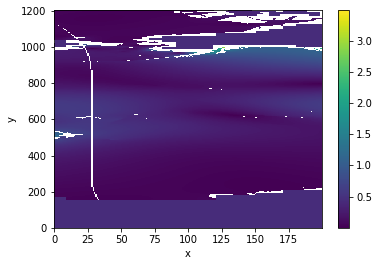

In [106]:
M2FESamp_on_SENEMO_GRID.isel(x=np.arange(400,600)).plot()

### Need to apply mask to regridded FES2014 data


In [89]:

# Create a land mask for the regridded FES data, with NaN over land
tl=domcfgZPS.top_level
tl=np.squeeze(tl)
tl=tl[1:-1,1:-1]
tl=tl.where(tl>0.5,drop=True)
tl
nanpatch=np.ones([151,1440])*np.nan
np.shape(nanpatch)
maskZPS=np.vstack((nanpatch,tl))


# Create a land mask for the MES grid, with NaN over land
tl=domcfgMES.top_level
tl=np.squeeze(tl)
tl=tl[1:-1,1:-1]
tl=tl.where(tl>0.5,drop=True)
tl
nanpatch=np.ones([151,1440])*np.nan
np.shape(nanpatch)
maskMES=np.vstack((nanpatch,tl))

M2FESamp_on_SENEMO_GRID_masked=M2FESamp_on_SENEMO_GRID*maskZPS
M2FESpha_on_SENEMO_GRID_masked=M2FESpha_on_SENEMO_GRID*maskZPS


NameError: name 'M2FESamp_on_SENEMO_GRID' is not defined

### write regridded data to files

In [ ]:
ds=M2FESamp_on_SENEMO_GRID_masked.to_dataset(name='M2amp')
ds.to_netcdf('../data/interim/FES2014_M2amp_on_SENEMO_GRID.nc')

ds=M2FESpha_on_SENEMO_GRID_masked.to_dataset(name='M2pha')
ds.to_netcdf('../data/interim/FES2014_M2pha_on_SENEMO_GRID.nc')

### ....or read them back in here

In [19]:
M2FESamp_on_SENEMO_GRID_masked = xr.open_dataset('../data/interim/FES2014_M2amp_on_SENEMO_GRID.nc')
M2FESpha_on_SENEMO_GRID_masked = xr.open_dataset('../data/interim/FES2014_M2pha_on_SENEMO_GRID.nc')


### calculate cell area appropriate for t-point variables (i.e. SSH, but not u, v) 

In [33]:
ZPScell_t_area=np.squeeze(domcfgZPS.e1t[0,1:-1,1:-1]*domcfgZPS.e2t[0,1:-1,1:-1])*maskZPS
MEScell_t_area=np.squeeze(domcfgMES.e1t[0,1:-1,1:-1]*domcfgMES.e2t[0,1:-1,1:-1])*maskMES

In [173]:
np.shape(maskMES)

(1205, 1440)

In [21]:
#sum the total area 
ZPS_cell_t_area_sum=ZPScell_t_area.sum(dim=None, keep_attrs=True)
MES_cell_t_area_sum=MEScell_t_area.sum(dim=None, keep_attrs=True)

In [22]:
ZPS_cell_t_area_sum  # As a check, this should equal approximately the global area of the ocean, approx. 3.61e14 m^2

<xarray.DataArray ()>
array(3.61659935e+14)
Coordinates:
    time_counter  float64 0.0

In [23]:
difference_as_fraction=(MES_cell_t_area_sum-ZPS_cell_t_area_sum)/ZPS_cell_t_area_sum

In [68]:
difference_as_fraction

<xarray.DataArray ()>
array(-0.00218884)
Coordinates:
    time_counter  float64 0.0

In [24]:
MES_cell_t_area_sum

<xarray.DataArray ()>
array(3.60868318e+14)

In [25]:
#Calculate error in M2 component of ssh w.r.t. FES2014, applying gridcell area weighting


err_ssh_GS1p1_tide=(ssh_GS1p1_tide_amp[1:-1,1:-1]-M2FESamp_on_SENEMO_GRID_masked.to_array())
err_ssh_GS1p2_full=(ssh_GS1p2_full_amp[1:-1,1:-1]-M2FESamp_on_SENEMO_GRID_masked.to_array())
err_ssh_EXPIWD02=(ssh_EXPIWD02_amp[1:-1,1:-1]-M2FESamp_on_SENEMO_GRID_masked.to_array())
err_ssh_GS1p6_full_IWD_soenhance_SSR_ice=(ssh_GS1p6_full_IWD_soenhance_SSR_ice_amp[1:-1,1:-1]-M2FESamp_on_SENEMO_GRID_masked.to_array())


#square the "errors" and apply gridcell area weights
err2_areawgt_ssh_GS1p1_tide=err_ssh_GS1p1_tide**2*ZPScell_t_area
err2_areawgt_ssh_GS1p2_full=err_ssh_GS1p2_full**2*MEScell_t_area
err2_areawgt_ssh_EXPIWD02=err_ssh_EXPIWD02**2*MEScell_t_area
err2_areawgt_ssh_GS1p6_full_IWD_soenhance_SSR_ice=err_ssh_GS1p6_full_IWD_soenhance_SSR_ice**2*MEScell_t_area


#take the sqrt of the (sum of the squared, weighted errors, divided by the total area)
rmse_areawgt_ssh_GS1p1_tide=np.sqrt(np.nansum(err2_areawgt_ssh_GS1p1_tide)/ZPS_cell_t_area_sum)
rmse_areawgt_ssh_GS1p2_full=np.sqrt(np.nansum(err2_areawgt_ssh_GS1p2_full)/MES_cell_t_area_sum)
rmse_areawgt_ssh_EXPIWD02=np.sqrt(np.nansum(err2_areawgt_ssh_EXPIWD02)/MES_cell_t_area_sum)
rmse_areawgt_ssh_GS1p6_full_IWD_soenhance_SSR_ice=np.sqrt(np.nansum(err2_areawgt_ssh_GS1p6_full_IWD_soenhance_SSR_ice)/MES_cell_t_area_sum)


In [26]:
rmse_areawgt_ssh_GS1p1_tide

<xarray.DataArray ()>
array(0.12385321)
Coordinates:
    time_counter  float64 0.0

In [27]:
rmse_areawgt_ssh_GS1p2_full

<xarray.DataArray ()>
array(0.13076302)

In [28]:
rmse_areawgt_ssh_EXPIWD02

<xarray.DataArray ()>
array(0.13012226)

In [29]:
rmse_areawgt_ssh_GS1p6_full_IWD_soenhance_SSR_ice

<xarray.DataArray ()>
array(0.12800686)

### Calculate the global integral of the KE, based on the M2 barotropic u and v

In [88]:
rho_0=1035.0 #as used in NEMO
#tidal harmonics are output in complex form and we want the
# amplitudes of each of the M2 u_baro and v_baro, so that they can be
# summed to form the KE for M2 vel_baro:   KE= 1/2 rho_o (|u_baro|**2+|vbaro|**2)

#Do these 1 run at a time, as quite easy to generate errors
print('GS1p1_tide')
u_baro_amp,u_baro_pha=amp_pha_from_re_im(ds_u_GS1p1_tide.M2x_u,ds_u_GS1p1_tide.M2y_u)
v_baro_amp,v_baro_pha=amp_pha_from_re_im(ds_v_GS1p1_tide.M2x_v,ds_v_GS1p1_tide.M2y_v)

#M2velsquared=(u_baro_amp**2+v_baro_amp**2)

#average the variables from u-, v-points onto the t-point

#coords are in (j,i) order

def interpolate_V_to_T(V):
    """
    Interpolate values from U-points to T-points in the east-west direction.
    
    Parameters:
    U (2D array): Variable located at U-points.
    
    Returns:
    T (2D array): Interpolated values at T-points.
    """
    T = 0.5 * (V[:-1, :] + V[1:, :])
    return T

def interpolate_U_to_T(U):
    """
    Interpolate values from V-points to T-points in the north-south direction.
    
    Parameters:
    V (2D array): Variable located at V-points.
    
    Returns:
    T (2D array): Interpolated values at T-points.
    """
    T = 0.5 * (U[:, :-1] + U[:, 1:])
    return T


M2velsquared=(interpolate_U_to_T(u_baro_amp[1:-1,1:]))**2+(interpolate_V_to_T(v_baro_amp[1:,1:-1]))**2
                             
M2velsquared_dA=M2velsquared*ZPScell_t_area
KE_per_gridcell=0.5*rho_0*M2velsquared_dA*deptht_ZPS[1:-1,1:-1]
KE_global_integral=np.nansum(KE_per_gridcell)

print('KE_global_integral',KE_global_integral)

###

print('GS1p2_full')
u_baro_amp,u_baro_pha=amp_pha_from_re_im(ds_u_GS1p2_full.M2x_u,ds_u_GS1p2_full.M2y_u)
v_baro_amp,v_baro_pha=amp_pha_from_re_im(ds_v_GS1p2_full.M2x_v,ds_v_GS1p2_full.M2y_v)


M2velsquared=(interpolate_U_to_T(u_baro_amp[1:-1,1:]))**2+(interpolate_V_to_T(v_baro_amp[1:,1:-1]))**2
M2velsquared_dA=M2velsquared*MEScell_t_area
KE_per_gridcell=0.5*rho_0*M2velsquared_dA*deptht_MES[1:-1,1:-1]
KE_global_integral=np.nansum(KE_per_gridcell)

print('KE_global_integral',KE_global_integral)

###

print('EXPIWD02')
u_baro_amp,u_baro_pha=amp_pha_from_re_im(ds_u_EXPIWD02.M2x_u,ds_u_EXPIWD02.M2y_u)
v_baro_amp,v_baro_pha=amp_pha_from_re_im(ds_v_EXPIWD02.M2x_v,ds_v_EXPIWD02.M2y_v)

M2velsquared=(interpolate_U_to_T(u_baro_amp[1:-1,1:]))**2+(interpolate_V_to_T(v_baro_amp[1:,1:-1]))**2
M2velsquared_dA=M2velsquared*MEScell_t_area
KE_per_gridcell=0.5*rho_0*M2velsquared_dA*deptht_MES[1:-1,1:-1]
KE_global_integral=np.nansum(KE_per_gridcell)

print('KE_global_integral',KE_global_integral)

###

print('GS1p6_full_IWD_soenhance_SSR_ice')
u_baro_amp,u_baro_pha=amp_pha_from_re_im(ds_u_GS1p6_full_IWD_soenhance_SSR_ice.M2x_u,ds_u_GS1p6_full_IWD_soenhance_SSR_ice.M2y_u)
v_baro_amp,v_baro_pha=amp_pha_from_re_im(ds_v_GS1p6_full_IWD_soenhance_SSR_ice.M2x_v,ds_v_GS1p6_full_IWD_soenhance_SSR_ice.M2y_v)

M2velsquared=(interpolate_U_to_T(u_baro_amp[1:-1,1:]))**2+(interpolate_V_to_T(v_baro_amp[1:,1:-1]))**2
M2velsquared_dA=M2velsquared*MEScell_t_area
KE_per_gridcell=0.5*rho_0*M2velsquared_dA*deptht_MES[1:-1,1:-1]
KE_global_integral=np.nansum(KE_per_gridcell)

print('KE_global_integral',KE_global_integral)

GS1p1_tide
KE_global_integral 3.507480675583277e+17
GS1p2_full
KE_global_integral 3.20528888292678e+17
EXPIWD02
KE_global_integral 3.2422394330545414e+17
GS1p6_full_IWD_soenhance_SSR_ice
KE_global_integral 3.139538286612927e+17


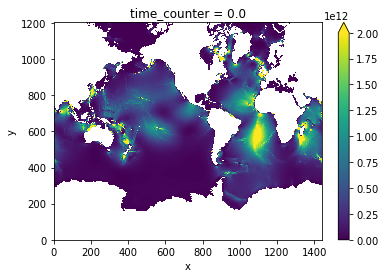

In [70]:
KE_per_gridcell.plot(vmin=0,vmax=2e12)